# Performance Comparison of Mean Embedding Method and CLS Embedding Method 
This notebook contains the code for section 4.2, where we compare the two embedding method for generating small molecule representation using ChemBERTa-2. This notebook is based on the work of Kaggle contributor Kishan Vavdara. 

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Read data 

In [2]:
de_train =   pd.read_parquet("/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet")
id_map = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/id_map.csv")
sample_submission = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv")

Here, we decided if we want to load the pre-generated embedding from the mean method or the CLS method

In [207]:
# chemical embeddings from chemberta
train_sm_emb = np.load('/kaggle/input/chemberta-v2-77-mtr/pad_false/train_ChemBERTa_v2_77MTR_mean_pad_False.npy')
test_sm_emb = np.load('/kaggle/input/chemberta-v2-77-mtr/pad_false/test_ChemBERTa_v2_77MTR_mean_pad_False.npy')
print(train_sm_emb.shape, test_sm_emb.shape)

(614, 600) (255, 600)


# Become one with data

In [3]:
adata = pd.read_parquet("/kaggle/input/open-problems-single-cell-perturbations/adata_train.parquet")

In [4]:
adata

,obs_id,gene,count,normalized_count
0,000006a87ba75b72,AATF,1,5.567933
1,000006a87ba75b72,ABHD12,1,5.567933
2,000006a87ba75b72,ABHD3,1,5.567933
3,000006a87ba75b72,AC004687.1,1,5.567933
4,000006a87ba75b72,AC009779.2,1,5.567933
...,...,...,...,...
416442307,ffffe67500d95d8d,ZSWIM7,1,4.205181
416442308,ffffe67500d95d8d,ZSWIM8,1,4.205181
416442309,ffffe67500d95d8d,ZUP1,1,4.205181
416442310,ffffe67500d95d8d,ZXDB,1,4.205181


In [5]:
gene_counts = adata.groupby('gene')['count'].sum()

In [12]:
gene_counts = gene_counts.sort_values()
df_gene_counts = pd.DataFrame(gene_counts)
df_gene_counts

,count
gene,
RGS7,1
AL157895.1,1
AC105235.1,1
CLDN10,1
AC011893.1,1
...,...
TPT1,15155765
MT-ATP6,15247464
B2M,21111239


In [208]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
350,T regulatory cells,TPCA-1,LSM-1136,NC(=O)Nc1sc(-c2ccc(F)cc2)cc1C(N)=O,False,2.175274,1.219289,2.396227,2.885988,3.384956,...,-1.062199,1.178715,0.180416,0.755145,1.809688,1.644712,0.701406,0.137341,0.230949,0.179458
377,NK cells,Dovitinib,LSM-1127,CN1CCN(c2ccc3[nH]c(-c4c(N)c5c(F)cccc5[nH]c4=O)...,False,0.214531,-0.115171,0.326515,0.032289,0.220971,...,0.438939,0.216506,-0.108654,-0.063070,0.006721,-0.593161,-0.044022,0.475729,0.356555,-0.038020
163,T regulatory cells,Tacalcitol,LSM-45518,C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CC[C@...,False,0.391257,-0.052922,0.540292,0.718991,1.083183,...,-1.755527,0.556352,0.089976,-0.000729,0.419802,1.020842,0.367313,0.486345,-0.856723,0.191009
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
132,T cells CD8+,MK-5108,LSM-36812,O=C(O)[C@]1(Cc2cccc(Nc3nccs3)n2)CC[C@@H](Oc2cc...,False,0.094873,1.067610,-0.745980,1.083842,0.638504,...,0.279780,0.489431,0.147217,0.292313,0.029266,0.330628,1.038142,-0.194884,1.078132,0.057001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,T regulatory cells,Raloxifene,LSM-3425,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,False,1.080779,0.226991,2.440729,2.581894,1.773980,...,-0.276043,0.768273,1.351487,2.359651,1.470219,0.866639,0.467307,0.663700,-0.122574,-0.315800
106,NK cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,-0.161665,0.269009,-1.770091,-0.198444,0.954753,...,0.131425,-1.112697,-0.589313,-0.660929,0.016530,0.319136,0.299521,-0.383452,0.267828,-1.100267
270,T regulatory cells,RN-486,LSM-47132,CN1CCN(c2ccc(Nc3cc(-c4cccc(-n5ccc6cc(C7CC7)cc(...,False,-0.304126,0.443651,0.688265,-0.101457,-0.005912,...,-0.855096,-0.499096,-0.211083,-0.495621,-0.233734,1.120530,-0.109096,0.128084,0.313468,-0.512444
435,NK cells,Doxorubicin,LSM-4062,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,False,0.482294,-1.262924,-0.545405,-0.497739,-0.750201,...,0.444958,0.029279,0.337660,0.025025,0.035943,0.691171,0.352091,0.046012,-0.760812,-0.168719


In [209]:
id_map.head()

,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867


In [210]:
df_drug_info = de_train[['sm_name','sm_lincs_id','SMILES']]
df_drug_info = df_drug_info.drop_duplicates()
df_drug_info

,sm_name,sm_lincs_id,SMILES
350,TPCA-1,LSM-1136,NC(=O)Nc1sc(-c2ccc(F)cc2)cc1C(N)=O
377,Dovitinib,LSM-1127,CN1CCN(c2ccc3[nH]c(-c4c(N)c5c(F)cccc5[nH]c4=O)...
163,Tacalcitol,LSM-45518,C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CC[C@...
609,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...
132,MK-5108,LSM-36812,O=C(O)[C@]1(Cc2cccc(Nc3nccs3)n2)CC[C@@H](Oc2cc...
...,...,...,...
563,RG7090,LSM-45680,Cc1nc(C#Cc2ccnc(Cl)c2)c(C)n1-c1ccc(F)cc1
325,Quizartinib,LSM-1037,CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cn4c(n3)sc3cc(OCC...
239,GW843682X,LSM-1014,COc1cc2ncn(-c3cc(OCc4ccccc4C(F)(F)F)c(C(N)=O)s...
490,PF-04691502,LSM-45239,COc1ccc(-c2cc3c(C)nc(N)nc3n([C@H]3CC[C@H](OCCO...


Visualizing more and staring at data for sometime will be more helpful for understanding but let's try building some simple model.

# Preprocess data 
We'll take only 'cell_type' and 'sm_name' as features and 18211 gene values as labels.

In [211]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
350,T regulatory cells,TPCA-1,LSM-1136,NC(=O)Nc1sc(-c2ccc(F)cc2)cc1C(N)=O,False,2.175274,1.219289,2.396227,2.885988,3.384956,...,-1.062199,1.178715,0.180416,0.755145,1.809688,1.644712,0.701406,0.137341,0.230949,0.179458
377,NK cells,Dovitinib,LSM-1127,CN1CCN(c2ccc3[nH]c(-c4c(N)c5c(F)cccc5[nH]c4=O)...,False,0.214531,-0.115171,0.326515,0.032289,0.220971,...,0.438939,0.216506,-0.108654,-0.063070,0.006721,-0.593161,-0.044022,0.475729,0.356555,-0.038020
163,T regulatory cells,Tacalcitol,LSM-45518,C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CC[C@...,False,0.391257,-0.052922,0.540292,0.718991,1.083183,...,-1.755527,0.556352,0.089976,-0.000729,0.419802,1.020842,0.367313,0.486345,-0.856723,0.191009
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
132,T cells CD8+,MK-5108,LSM-36812,O=C(O)[C@]1(Cc2cccc(Nc3nccs3)n2)CC[C@@H](Oc2cc...,False,0.094873,1.067610,-0.745980,1.083842,0.638504,...,0.279780,0.489431,0.147217,0.292313,0.029266,0.330628,1.038142,-0.194884,1.078132,0.057001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,T regulatory cells,Raloxifene,LSM-3425,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,False,1.080779,0.226991,2.440729,2.581894,1.773980,...,-0.276043,0.768273,1.351487,2.359651,1.470219,0.866639,0.467307,0.663700,-0.122574,-0.315800
106,NK cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,-0.161665,0.269009,-1.770091,-0.198444,0.954753,...,0.131425,-1.112697,-0.589313,-0.660929,0.016530,0.319136,0.299521,-0.383452,0.267828,-1.100267
270,T regulatory cells,RN-486,LSM-47132,CN1CCN(c2ccc(Nc3cc(-c4cccc(-n5ccc6cc(C7CC7)cc(...,False,-0.304126,0.443651,0.688265,-0.101457,-0.005912,...,-0.855096,-0.499096,-0.211083,-0.495621,-0.233734,1.120530,-0.109096,0.128084,0.313468,-0.512444
435,NK cells,Doxorubicin,LSM-4062,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,False,0.482294,-1.262924,-0.545405,-0.497739,-0.750201,...,0.444958,0.029279,0.337660,0.025025,0.035943,0.691171,0.352091,0.046012,-0.760812,-0.168719


In [212]:
# Create features and and labels for reverse model 18211 features and 152 labels for true model
features_columns = ["cell_type", "sm_name"]
labels_columns=["cell_type","sm_name","sm_lincs_id","SMILES","control"]
labels = de_train.drop(columns=labels_columns)
features = pd.DataFrame(de_train, columns=features_columns)

In [213]:
features

,cell_type,sm_name
350,T regulatory cells,TPCA-1
377,NK cells,Dovitinib
163,T regulatory cells,Tacalcitol
609,T regulatory cells,Atorvastatin
132,T cells CD8+,MK-5108
...,...,...
71,T regulatory cells,Raloxifene
106,NK cells,Dabrafenib
270,T regulatory cells,RN-486
435,NK cells,Doxorubicin


In [214]:
labels

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
350,2.175274,1.219289,2.396227,2.885988,3.384956,3.267348,0.134622,1.829941,-0.956191,-0.404039,...,-1.062199,1.178715,0.180416,0.755145,1.809688,1.644712,0.701406,0.137341,0.230949,0.179458
377,0.214531,-0.115171,0.326515,0.032289,0.220971,-0.463554,1.016849,0.153039,0.292684,0.038020,...,0.438939,0.216506,-0.108654,-0.063070,0.006721,-0.593161,-0.044022,0.475729,0.356555,-0.038020
163,0.391257,-0.052922,0.540292,0.718991,1.083183,1.021599,-0.097250,0.306833,-3.331719,0.235092,...,-1.755527,0.556352,0.089976,-0.000729,0.419802,1.020842,0.367313,0.486345,-0.856723,0.191009
609,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,-0.544709,0.282458,-0.431359,-0.364961,0.043123,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
132,0.094873,1.067610,-0.745980,1.083842,0.638504,0.307649,-0.038108,0.772186,-0.736735,-0.462323,...,0.279780,0.489431,0.147217,0.292313,0.029266,0.330628,1.038142,-0.194884,1.078132,0.057001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1.080779,0.226991,2.440729,2.581894,1.773980,1.989227,-0.074095,0.906555,2.214564,-0.182784,...,-0.276043,0.768273,1.351487,2.359651,1.470219,0.866639,0.467307,0.663700,-0.122574,-0.315800
106,-0.161665,0.269009,-1.770091,-0.198444,0.954753,1.155912,-0.312552,0.621897,-0.154055,0.331780,...,0.131425,-1.112697,-0.589313,-0.660929,0.016530,0.319136,0.299521,-0.383452,0.267828,-1.100267
270,-0.304126,0.443651,0.688265,-0.101457,-0.005912,-0.004914,-0.247434,0.281614,-0.915735,-0.032908,...,-0.855096,-0.499096,-0.211083,-0.495621,-0.233734,1.120530,-0.109096,0.128084,0.313468,-0.512444
435,0.482294,-1.262924,-0.545405,-0.497739,-0.750201,0.959704,0.527966,1.198200,-0.482740,0.635863,...,0.444958,0.029279,0.337660,0.025025,0.035943,0.691171,0.352091,0.046012,-0.760812,-0.168719


In [215]:
train_sm_emb_df = pd.DataFrame(train_sm_emb)
test_sm_emb_df = pd.DataFrame(test_sm_emb)
test_sm_emb_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.122925,0.0,0.035734,0.695578,-0.327100,-0.456733,0.084535,0.391682,-0.347453,0.221594,...,-0.181728,-0.155568,0.136546,0.009364,0.236327,-0.392904,-0.206561,-0.329538,-0.325399,0.635164
1,0.000866,0.0,0.281953,0.038660,-0.098784,0.544995,-0.348214,-0.396752,-1.200992,0.140444,...,-0.422931,-0.139193,0.188181,-0.268241,0.413389,-0.328540,-0.132699,0.703512,0.306015,0.006399
2,-0.068357,0.0,0.485367,0.043183,-0.334481,-0.017123,-0.109150,-0.307422,-1.057204,-0.217194,...,-0.185077,-0.410322,-0.020534,-0.069112,0.656705,-0.809060,-0.281679,0.548517,0.511771,0.250180
3,0.390734,0.0,-0.818989,-0.014225,-0.280093,-0.540723,-0.011250,-0.159010,-0.045694,-0.203750,...,-1.126925,0.253930,-0.241510,0.125903,-0.138344,0.101344,-0.137822,0.623891,0.053404,-0.327462
4,-0.317788,0.0,-0.283000,-0.353593,0.148982,0.405540,0.527179,-0.193681,0.781735,-0.574237,...,-0.219567,-0.593894,-0.198462,0.255728,0.079366,-0.025736,-0.327169,-0.554904,-0.147572,0.175943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.686481,0.0,-0.143387,0.263486,0.251930,0.141210,-0.096446,0.160593,-0.524156,0.333404,...,0.554585,-0.404585,0.471937,0.076754,0.642681,-0.230166,-0.139125,-0.735335,0.456096,0.529315
251,-0.031452,0.0,0.004269,-0.339414,-0.162245,0.395121,-0.438980,-0.426928,0.042139,-0.590532,...,-0.053768,-0.117900,-0.071486,0.140139,0.081705,-0.840349,-0.362660,-0.427412,-0.025805,0.259560
252,0.318103,0.0,0.353240,0.237558,0.176419,-0.637848,-0.087565,-0.012998,-0.546407,0.222405,...,-0.044928,-0.026686,-0.233929,0.389529,0.314446,-0.861696,0.314512,0.502273,-0.068138,-0.132695
253,-0.071004,0.0,-0.371650,-1.014584,-0.289111,0.384991,-0.041640,0.300125,0.807499,0.681000,...,0.209175,-0.433531,-0.026121,0.350386,-0.172590,-0.214599,-0.211576,0.317099,0.175234,-0.190767


In [216]:
features_merged = pd.concat([features, train_sm_emb_df],axis=1)
features_merged = features_merged.drop(columns = ["sm_name"])

In [217]:
# Get test data 
test_data = pd.DataFrame(id_map, columns=features_columns)

In [218]:
test_data_merged = pd.concat([test_data, test_sm_emb_df],axis=1)
test_data_merged = test_data_merged.drop(columns = ["sm_name"])

In [219]:
#features = features.merge(df_drug_info, on="sm_name", how="left")

In [220]:
# features = features[["cell_type","SMILES"]]
# features

In [221]:
# test_data = test_data.merge(df_drug_info, on="sm_name", how="left")
# test_data = test_data[["cell_type","SMILES"]]
# test_data

In [222]:
de_train = de_train.sample(frac=1.0, random_state=42)

# Process categorical data
We'll use OneHotEncode for categorical data

In [223]:
features = features_merged
test_data = test_data_merged

In [224]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the encoder
encoder = OneHotEncoder()

# Fit the encoder on features
encoder.fit(features[["cell_type"]])

# Transform the features into one-hot encoded format
one_hot_encode_features = encoder.transform(features[["cell_type"]])

# Transform the test data(id_map)
one_hot_test = encoder.transform(test_data[["cell_type"]])

In [225]:
# check shape
one_hot_encode_features.toarray().shape, one_hot_test.toarray().shape

((614, 6), (255, 6))

In [226]:
# check one sample
one_hot_encode_features.toarray()[0]

array([0., 0., 0., 0., 0., 1.])

In [227]:
one_hot_encode_features

<614x6 sparse matrix of type '<class 'numpy.float64'>'
	with 614 stored elements in Compressed Sparse Row format>

In [228]:
train_cell_type_df = pd.DataFrame.sparse.from_spmatrix(one_hot_encode_features)
test_cell_type_df = pd.DataFrame.sparse.from_spmatrix(one_hot_test)

In [229]:
column_mapping = {old_column: f'ct_{old_column}' for old_column in range(6)}
train_cell_type_df = train_cell_type_df.rename(columns=column_mapping)
test_cell_type_df = test_cell_type_df.rename(columns=column_mapping)

In [230]:
features_606 = pd.concat([features,train_cell_type_df],axis=1)
features_606 = features_606.drop(columns="cell_type")
test_data_606 = pd.concat([test_data,test_cell_type_df],axis=1)
test_data_606 = test_data_606.drop(columns="cell_type")

In [231]:
features_with_label = pd.concat([features_606,labels],axis = 1)

In [232]:
features_with_label = features_with_label.sample(frac=1.0, random_state=42)
features_606 = features_with_label.iloc[:, :606]
labels = features_with_label.iloc[:, 606:]

In [233]:
features_606

,0,1,2,3,4,5,6,7,8,9,...,596,597,598,599,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5
563,0.092454,0.0,-0.081104,-0.399519,0.384016,-0.070985,0.233767,-0.192257,0.032198,0.371729,...,-0.030255,0.175948,0.079086,-0.501463,0.0,0.0,0.0,0.0,0.0,1.0
554,-0.008523,0.0,0.294704,-0.283571,0.417388,-0.007126,-0.469675,-0.205479,-0.386680,-0.452240,...,0.102622,-0.550522,0.150461,-0.431876,0.0,0.0,1.0,0.0,0.0,0.0
395,-0.048939,0.0,-0.265790,0.041247,-0.763774,0.702886,-0.007885,0.258667,0.429206,-0.003753,...,-0.344290,0.651846,0.367652,0.117263,0.0,0.0,0.0,0.0,0.0,1.0
71,0.662826,0.0,-0.442468,0.038528,0.352227,0.451729,-0.645996,-0.080946,-0.416384,-0.753075,...,0.262398,-0.352322,0.225743,0.200770,0.0,0.0,1.0,0.0,0.0,0.0
289,-0.574434,0.0,-0.787934,-0.213684,-0.201238,-0.619507,0.722682,-0.415111,0.711623,0.156397,...,-0.346129,0.114149,1.223404,0.040226,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0.303357,0.0,0.352111,-0.235471,-0.319022,-0.330748,0.555206,-0.187447,0.492102,0.287059,...,-0.206672,0.870590,0.354348,0.107422,0.0,0.0,0.0,0.0,1.0,0.0
425,-0.150139,0.0,0.603655,-0.410529,-0.185029,0.243148,-0.553977,0.051713,-0.477973,0.670138,...,-0.232777,-0.789056,-0.332813,0.002954,1.0,0.0,0.0,0.0,0.0,0.0
587,-0.071062,0.0,-0.141881,-0.056490,-0.024862,0.159714,0.425026,0.050404,-0.401820,-0.725705,...,-0.104037,-0.203142,1.024073,-0.370373,0.0,0.0,0.0,1.0,0.0,0.0
232,-0.132365,0.0,0.631376,0.141729,-0.116184,-0.359747,-0.086041,-0.367992,-1.220473,-0.179181,...,-0.105611,0.664085,0.165008,0.418992,0.0,0.0,0.0,0.0,0.0,1.0


In [234]:
labels

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
563,-0.023889,-0.096944,-0.066767,-0.006567,-0.413428,0.047984,-0.043985,-0.215520,0.471340,-0.496827,...,-0.407023,0.432989,0.165888,0.012636,1.051143,-0.159455,0.243229,-0.202144,-0.340575,-0.015877
554,0.526769,0.372027,0.083484,0.037057,0.534532,1.148947,0.142575,0.244986,0.145960,-0.138639,...,0.765946,0.809738,0.407896,0.724324,0.989144,1.156748,0.278976,0.341523,-0.481920,0.007459
395,-0.186269,-0.136718,-0.352898,0.122036,0.205099,-0.273279,0.075596,-0.521142,0.397400,-0.632809,...,-0.021900,-0.322762,-1.827559,-0.036431,0.317973,0.278413,0.175440,0.589622,0.508453,0.137014
71,1.080779,0.226991,2.440729,2.581894,1.773980,1.989227,-0.074095,0.906555,2.214564,-0.182784,...,-0.276043,0.768273,1.351487,2.359651,1.470219,0.866639,0.467307,0.663700,-0.122574,-0.315800
289,0.166139,0.999359,-1.007809,-3.895207,-0.613800,1.522304,1.579135,1.872215,0.345586,2.756892,...,-0.068473,0.482761,-0.844218,-0.613151,-0.336750,1.042107,-0.311373,3.130099,-0.087640,-4.021713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,1.181036,3.652341,-7.026508,-17.801989,-0.656651,7.221029,-0.272875,0.343039,2.793187,5.915413,...,4.361655,0.558856,-0.809408,0.265743,-0.056795,-0.019083,-0.140576,3.909364,-1.252862,-1.467913
425,0.150156,-0.052033,-0.030772,-0.179556,0.503898,0.143701,-0.141973,-0.339176,0.444140,-0.559486,...,0.100484,0.970955,-0.132709,-0.342612,0.019547,0.662981,0.073615,0.405872,1.155630,-1.310131
587,0.095160,-0.082748,-0.054920,-0.324506,0.613975,0.015987,-0.245756,0.214504,-0.162760,0.003040,...,0.127027,0.708832,-0.173032,1.133132,-0.078863,0.282025,0.368643,-0.028557,0.787231,0.126548
232,-0.476270,0.022764,-0.511663,-0.361534,-0.413354,-0.410677,-0.122642,0.426313,0.000656,0.537104,...,-1.826637,0.553873,-0.024311,0.056507,-0.737965,0.027901,-0.750793,0.546028,-0.023894,-1.062894


In [235]:
one_hot_encode_features = features_606.to_numpy()
one_hot_test = test_data_606.to_numpy()

In [236]:
print(one_hot_encode_features.shape, one_hot_test.shape)

(614, 606) (255, 606)


# Split Data into training, validation and test sets 

In [237]:
from sklearn.model_selection import train_test_split

# Split the data into 70% training, 15% validation, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(one_hot_encode_features, labels.values, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [238]:
# Printing the shapes of the data splits
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (429, 606)
X_val shape: (92, 606)
X_test shape: (93, 606)
y_train shape: (429, 18211)
y_val shape: (92, 18211)
y_test shape: (93, 18211)


In [239]:
# We also get full features for final training 
full_features = one_hot_encode_features
full_labels = labels.values

In [240]:
print("full_features shape:", full_features.shape)
print("full_labels shape:", full_labels.shape)

full_features shape: (614, 606)
full_labels shape: (614, 18211)


# Auxillary functions 

In [241]:
from tensorflow.keras.callbacks import ModelCheckpoint

def create_model_checkpoint(filepath, monitor='val_mae', save_best_only=True,
                            save_weights_only=True, mode='auto', verbose=0):
    """
    Create a ModelCheckpoint callback for saving the best model weights during training.

    Args:
        filepath (str): Filepath to save the best weights.
        monitor (str): Metric to monitor (e.g., 'val_loss' or 'val_mae').
        save_best_only (bool): Save only the best weights.
        save_weights_only (bool): Save only the model's weights, not the entire model.
        mode (str): One of {'auto', 'min', 'max'}. In 'min' mode, it saves when the monitored metric decreases.
        verbose (int): Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

    Returns:

        keras.callbacks.ModelCheckpoint: ModelCheckpoint callback.
    """
    checkpoint = ModelCheckpoint(
        filepath=filepath,
        monitor=monitor,
        save_best_only=save_best_only,
        save_weights_only=save_weights_only,
        mode=mode,
        verbose=verbose
    )
    return checkpoint

In [251]:
def plot_training_history(history, metrics):
    """
    Plot training history curves for loss and evaluation metrics on the same line.

    Args:
        history (keras.callbacks.History): Training history object.
        metrics (list): List of metric names to plot.

    Returns:
        None
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss', color="blue")
    plt.plot(epochs, val_loss, label='Validation Loss', color="red")
    
    plt.title('Loss vs. Epochs with CLS Embedding')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot specified evaluation metrics on the same line
    for metric in metrics:
        train_metric_name = f'Training {metric.capitalize()}'
        val_metric_name = f'Validation {metric.capitalize()}'
        train_metric = history.history[metric]
        val_metric = history.history['val_' + metric]

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_metric, label=train_metric_name, color="green")
        plt.plot(epochs, val_metric, label=val_metric_name, color="orange")
        
    plt.title('Metrics vs. Epochs with CLS Embedding')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


In [252]:
from sklearn.metrics import mean_absolute_error

def calculate_mae_and_mrrmse(model, data, y_true):
    """
    Calculate Mean Absolute Error (MAE) and Mean Rowwise Root Mean Squared Error (MRRMSE).

    Parameters:
    - model: The trained  model.
    - data: The input data for prediction.
    - y_true: The true target values.
    - scaler: The scaler used for data normalization.

    Returns:
    - None
    """
    # Predict using the model
    y_pred_original = model.predict(data, batch_size=1)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true , y_pred_original)
    
    # Calculate Mean Rowwise Root Mean Squared Error (MRRMSE)
    rowwise_rmse = np.sqrt(np.mean(np.square(y_true - y_pred_original), axis=1))
    mrrmse_score = np.mean(rowwise_rmse)
    
    # Print the results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Rowwise Root Mean Squared Error (MRRMSE): {mrrmse_score}")

In [253]:
def mean_rowwise_rmse_loss(y_true, y_pred):
    """
    Custom loss function to calculate the Mean Rowwise Root Mean Squared Error (RMSE) loss.

    Parameters:
    - y_true: The true target values.
    - y_pred: The predicted values.

    Returns:
    - Mean Rowwise RMSE loss as a scalar tensor.
    """
    # Calculate RMSE for each row
    rmse_per_row = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    # Calculate the mean of RMSE values across all rows
    mean_rmse = tf.reduce_mean(rmse_per_row)
    
    return mean_rmse

In [254]:
def custom_mean_rowwise_rmse(y_true, y_pred):
    """
    Custom metric to calculate the Mean Rowwise Root Mean Squared Error (RMSE).

    Parameters:
    - y_true: The true target values.
    - y_pred: The predicted values.

    Returns:
    - Mean Rowwise RMSE as a scalar tensor.
    """
    # Calculate RMSE for each row
    rmse_per_row = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    # Calculate the mean of RMSE values across all rows
    mean_rmse = tf.reduce_mean(rmse_per_row)
    
    return mean_rmse

Beautiful functions let's start experiment with building models

# Build the model

In [255]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

In [256]:
tf.random.set_seed(42)

model_2 = Sequential([ 
    Dense(256),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.2),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(18211,activation= "linear")
])


model_2.compile(loss="mae", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

history_2 = model_2.fit(X_train, y_train,
                       epochs=30,
                       verbose=1, #train in silent mode
                       validation_data=(X_val,y_val),
                       callbacks=[create_model_checkpoint("model_2", monitor="val_mae")])

Epoch 1/30
14/14 [==============================] - 3s 35ms/step - loss: 0.8669 - mae: 0.8669 - val_loss: 0.6789 - val_mae: 0.6789
Epoch 2/30
14/14 [==============================] - 0s 15ms/step - loss: 0.8589 - mae: 0.8589 - val_loss: 0.6781 - val_mae: 0.6781
Epoch 3/30
14/14 [==============================] - 0s 13ms/step - loss: 0.8535 - mae: 0.8535 - val_loss: 0.6791 - val_mae: 0.6791
Epoch 4/30
14/14 [==============================] - 0s 13ms/step - loss: 0.8486 - mae: 0.8486 - val_loss: 0.6822 - val_mae: 0.6822
Epoch 5/30
14/14 [==============================] - 0s 13ms/step - loss: 0.8421 - mae: 0.8421 - val_loss: 0.6849 - val_mae: 0.6849
Epoch 6/30
14/14 [==============================] - 0s 13ms/step - loss: 0.8416 - mae: 0.8416 - val_loss: 0.6948 - val_mae: 0.6948
Epoch 7/30
14/14 [==============================] - 0s 13ms/step - loss: 0.8359 - mae: 0.8359 - val_loss: 0.6992 - val_mae: 0.6992
Epoch 8/30
14/14 [==============================] - 0s 13ms/step - loss: 0.8306 - m

In [257]:
model_2.load_weights("model_2")
calculate_mae_and_mrrmse(model=model_2, data=X_test, y_true=y_test)

93/93 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.8599134500880431
Mean Rowwise Root Mean Squared Error (MRRMSE): 1.3786464279856365


In [258]:
calculate_mae_and_mrrmse(model=model_2, data=full_features, y_true=full_labels)

614/614 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 0.8293282099888495
Mean Rowwise Root Mean Squared Error (MRRMSE): 1.2681131043217246


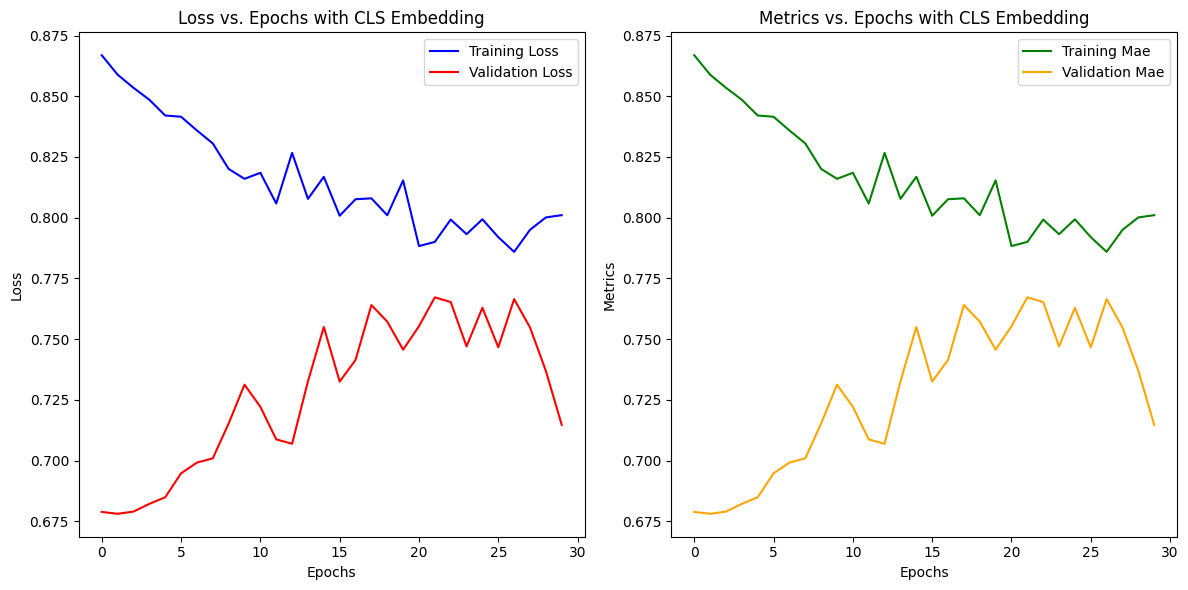

In [259]:
#  Visualize the learning from our helper functions
plot_training_history(history_2, metrics=["mae"])

> Changing metrics and using same model

In [260]:
tf.random.set_seed(42)

# clone model 2
model_3 = tf.keras.models.clone_model(model_2)

model_3.compile(loss="mae", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[custom_mean_rowwise_rmse])

history_3 = model_3.fit(X_train, y_train,
                       epochs=25,
                       verbose=0, #train in silent mode
                       validation_data=(X_val,y_val),
                       callbacks=[create_model_checkpoint("model_3", monitor="val_custom_mean_rowwise_rmse")])

In [261]:
model_3.load_weights("model_3")
calculate_mae_and_mrrmse(model=model_3, data=X_test, y_true=y_test)

93/93 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.8546912437706898
Mean Rowwise Root Mean Squared Error (MRRMSE): 1.3715248485090974


In [262]:
calculate_mae_and_mrrmse(model=model_3, data=full_features, y_true=full_labels)

614/614 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 0.8184674610842095
Mean Rowwise Root Mean Squared Error (MRRMSE): 1.2557364039904388


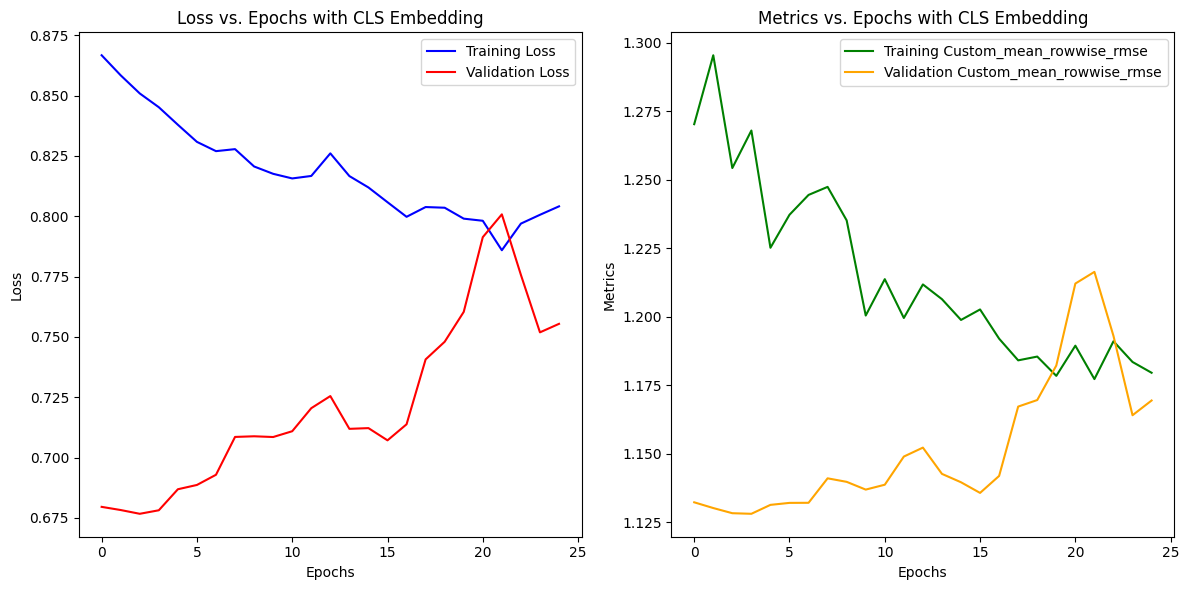

In [263]:
plot_training_history(history_3, metrics=["custom_mean_rowwise_rmse"])